In [28]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [29]:

ratings = pd.read_table('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies_data = pd.read_table('ml-100k/u.item', sep='|', encoding='latin-1', names=['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])
users = pd.read_table('ml-100k/u.user', sep='t', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

In [30]:
combined = ratings.merge(movies_data, left_on='item_id', right_on='movie_id', how='inner')[['user_id', 'item_id', 'rating', 'title']]

combined = combined.dropna()

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
user_item_matrix = combined.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
similarity_matrix = cosine_similarity(user_item_matrix)

target_user = 1
user_index = user_item_matrix.index.get_loc(target_user)
user_similarities = similarity_matrix[user_index]
similar_users = user_item_matrix.index[similarity_matrix[user_index].argsort()[::-1][1:11]]

In [32]:
unseen_movies = combined[combined['user_id'] == target_user]['item_id'].drop_duplicates()
all_movies = combined['item_id'].drop_duplicates()
recommended_movie_ids = [movie for movie in all_movies if movie not in unseen_movies]

In [33]:
recommendation_scores = {}
for movie in recommended_movie_ids:
    movie_ratings = combined[combined['item_id'] == movie][['user_id', 'rating']]
    common_users = movie_ratings[movie_ratings['user_id'].isin(similar_users)]
    
    if not common_users.empty:
        common_similarities = [user_similarities[user_item_matrix.index.get_loc(u)] for u in common_users['user_id']]
        weighted_score = np.sum(np.array(common_similarities) * common_users['rating'].values)
        recommendation_scores[movie] = weighted_score / np.sum(common_similarities)
    else:
        recommendation_scores[movie] = 0


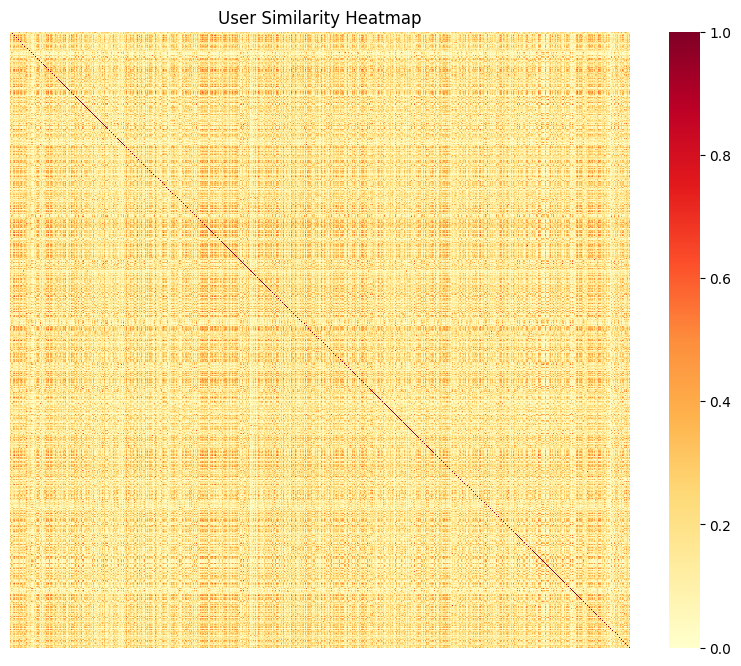

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('User Similarity Heatmap')
plt.show()